# Introduction

### Quantum Advantage and hardware
Computers have become essential elements in modern societies, allowing us to efficiently solve numerous problems. Nonetheless, there are certain tasks of great interest that cannot even be solved with the most advanced supercomputers. The idea of quantum computing
first emerged in the context of using a quantum device to study systems governed by the laws of quantum mechanics in view of the difficulties of classical computers to simulate such behaviours. Over the years, and after it had been shown that a quantum computer could theoretically bring an exponential reduction in computation time for certain problems, the efforts for developing this new computing paradigm have increased considerably, with an special focus in the advancement of the quantum hardware and the
search of practical applications that go beyond artificial proof-of-concepts, also known as quantum advantage. 


For classical computers the minimum unit of information is a bit, which can be either in the 0 or the 1 configuration. For a quantum computer the analogous unit of quantum information is a qubit, a two-level quantum system that can be in any combination of the states |0⟩ and |1⟩. The potential of quantum computation relies on the quantum properties of qubits such as entanglement, superposition or tunnelling effects which build up a quantum logic that allows to manipulate the information in a more efficient manner than classical logic. The hardware implementation of a qubit remains a very
challenging and still open task, with many different approaches competing to enhance qubit control and reduce the noise from the environment, e.g. superconducting qubits, trapped ions, neutral atoms, optical qubits, among others.

<p style="text-align: center"><img src="https://i.imgur.com/vlMOdI5.png" width=800 /></p>

### QComputation Paradigms

There are also different proposed models of quantum computation but the most popular one is the so-called gate-based model, or digital model, in which the problem is encoded in a sequence of quantum logic gates that canbe understood mathematically as unitary operators applied to a set of qubits. There are several sets of single and two-qubit gates that are known for being able to perform universal computation, i.e., any quantum problem can be encoded in a sequence of such set of gates. 

# Qubit routing problem

In the digital model of quantum computation, an crucial type of operation to interact between qubits are the **two-qubit gates**, which act on one or two qubits at a time. However, in realistic hardware the qubits are typically laid out in a fixed two or three dimensional topology where gates may only be applied between connected qubits. In order for a circuit to be executed on such hardware, it must be modified to ensure that whenever two qubits are required to interact, they are connected.

We refer to the task of modifying a circuit to conform to the memory layout of a specific quantum computer as the qubit routing problem. When non-connected qubits are required to interact we can insert additional SWAP gates to exchange a qubit state with its connected neighbour, moving its state until it can interact with its desired partner. In general many – or even all – of the qubits may need to be swapped, making this problem non-trivial. Since quantum algorithms are usually designed without reference to the connectivity constraints of any particular hardware, a solution to the routing problem is required before a quantum circuit can be executed. Therefore qubit routing forms a necessary stage of any compiler for quantum software.

<p style="text-align: center"><img src="https://i.imgur.com/7KvVAF5.png" width=700 /></p>

*FIG. 0 The transpiler takes an abstract (theoretical) quantum circuit as input and produces an optimized physical quantum circuit (ready to execute in real hardware) as an output. From 10.48550/arXiv.2306.15020.*

Current quantum computers – the so-called NISQ (Noisy Intermediate Scale Quantum) devices – impose additional constraints. Their short coherence times and relatively low fidelity gates require that the circuit depth and the total number of gates are both as low as possible. As routing generally introduces extra gates into a circuit, increasing its size and depth, it is crucial that the circuit does not grow too much, or its performance will be compromised.

We represent a quantum computer as a graph where nodes are physical qubits and edges are the allowed 2-qubit interactions. Since the circuit model assumes we can realise a two-qubit gate between any pair of qubits, it is equivalent to the complete graph (Fig. 1a). Realistic qubit architectures are connectivity limited: for instance, in most superconducting platforms the qubit interaction graph must be planar; ion traps present more flexibility, but are still not fully connected. For now we will use the ring graph (Fig. 1b) as a simple example. Given such a restricted graph, our goal is to emulate the complete graph with minimal additional cost. 

From this point of view, the routing problem can be stated as follows. Given *(i)* an arbitrary quantum circuit and *(ii)* a connected graph specifying the allowed qubit interactions, we must produce a new quantum circuit which is equivalent to the input circuit, but uses only those interactions permitted by the specification graph. Provided the device has at least as many qubits as the input circuit then a solution always exists; our objective is to minimise the size of the output circuit.


<p style="text-align: center"><img src="https://i.imgur.com/eH9Wyoh.png" width=500 /></p>

*FIG.1 Nodes in the graph represent physical qubits and edges are the allowed interactions. (a) The circuit
model assumes all-to-all communication between qubits, *i.e*. a complete graph and (b) a physically realistic
one-dimensional nearest neighbour cyclic graph, the ring.*


### Cell for installing necessary packages:

In [ ]:
# Uncomment to install the necessary packages
# !pip install numpy
# !pip install scipy
# !pip install matplotlib
# !pip install jupyter
# !pip install qiskit[visualization]==1.2
# # For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'==1.2
# !pip install qiskit_algorithms
# !pip install qiskit_aer >= 0.14
# !pip install qiskit_ibm_runtime
# !pip install qiskit_ibm_transpiler

### Some helper functions, for plotting:

In [ ]:
from matplotlib.pyplot import figure
from qiskit import QuantumCircuit


def plotting_circuit_with_title(circuit: QuantumCircuit, title: str):
    """Plots the given Quantum Circuit, with the passed title.

    Args:
        circuit (QuantumCircuit): The quantum circuit to plot together with its title.
        title (str): Title of the plot.
    """
    ax = figure().add_subplot()
    ax.set_title(title)
    circuit.draw(output="mpl", ax=ax)

    return ax


def adding_timeslices_to_circuit_plot(circuit: QuantumCircuit, title: str, timeslices: list[float]):
    """This function adds vertical lines to the circuit plot to divide the circuit into time slices.

    Args:
        circuit (QuantumCircuit): The quantum circuit to plot together with the time slices.
        timeslices (list): A list of floats representing the horizonal positions of the time slices to plot.
    """

    ax = plotting_circuit_with_title(circuit, title)

    # divide the circuit into time slices
    for x in timeslices:
        ax.axvline(x, color="red", linestyle="--")


## A. Example: routing on a ring

Let’s consider the problem of routing the following circuit (FIG.2) on the ring graph of FIG. 1(b).

<Axes: title={'center': 'FIG. 2'}>

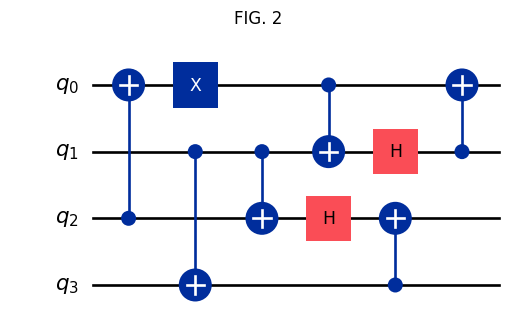

In [13]:
from qiskit import QuantumCircuit

# Creating the circuit:
c = QuantumCircuit(4)
c.cx(2, 0)
c.cx(1, 3)
c.x(0)
c.cx(1, 2)
c.cx(0, 1)
c.h(1)
c.h(2)
c.cx(1, 0)
c.cx(3, 2)

# Plotting circuit with title
plotting_circuit_with_title(circuit=c, title="FIG. 2")

The first step is to divide the circuit into timesteps, also called slices. Loosely speaking, a timestep consists of a subcircuit where the gates act on disjoint sets of qubits and could in principle all be performed simultaneously. The single qubit gates have no bearing on the routing problem so can be ignored, and thus a timestep can be reduced to a set of qubit pairs that are required to interact via some 2-qubit gate. 

In [ ]:
# Your code goes here:
timeslices = [...]  # A list of floats representing the horizonal positions of the time slices to plot.


# Calling the function, with your given parameters:
adding_timeslices_to_circuit_plot(circuit=c, title="FIG. 3", timeslices=timeslices)

Next, the virtual qubits of the circuit ($q_k$) must be mapped to the nodes of the graph ($K$, physical qubits). For our example a reasonable initial mapping is $q_0 \rightarrow 0, q_1 \rightarrow 2, q_2 \rightarrow 1, q_3 \rightarrow 3$ as shown in FIG. 4. This has the advantage that the qubits which interact in the first timestep are connected in the graph, and the same for the second timestep.

<p style="text-align: center"><img src="https://i.imgur.com/uA65Mwv.png" width=500 /></p>

*FIG. 4. (a) An initial mapping of virtual qubits to nodes. (b) How the graph ends. Highlighted nodes are labelled with the mapped qubit.*

However at the third timestep our luck has run out: the CNOT gate between $q_0$ and $q_1$ is not possible in the current configuration. We must add SWAP gates to exchange virtual qubits to enable the desired two-qubit interactions. In the example there are two candidates: swapping nodes 0 and 1, or swapping nodes 1 and 2, yielding the configurations shown in FIG. 5.

<p style="text-align: center"><img src="https://i.imgur.com/LkJSYzj.png" width=550 /></p>

*FIG. 5. (a) Qubit mapping to nodes if $q_0$ and $q_2$ swap positions. (b) Qubit mapping to nodes if $q_1$ and $q_2$ swap positions.*

Looking ahead to the final slice – slice 4 has no 2-qubit gates so can be ignored – and then in the last slice, we see that $q_2$ and $q_3$ will need to interact. In configuration (a) these qubits are distance 3 apart, and hence two additional swaps will be needed to bring them together. In configuration (b) however they are already connected. As we want to minimise the number of additional elements to our circuit we choose configuration (b), swaping nodes 1 and 2 to yield the final circuit shown in FIG. 6.

In [ ]:
from qiskit import QuantumCircuit

routed_c = QuantumCircuit(4)
routed_c.cx(1, 0)  # Adding first CNOT, for reference

# Your code goes here, continue the circuit:
#
#

routed_c.swap(2, 1)  # Adding the middle and unique needed SWAP

# Your code goes here, finish the circuit:
#
#

print(f"Circuit detph: {routed_c.depth()}")
plotting_circuit_with_title(circuit=routed_c, title="FIG. 6")

Comparing this Figure, with FIG 2. or FIG 3., notice how the 2 middle qubits start interchanged, due to the initial mapping of virtual qubits to physical ones (nodes) we selected ($q_0 \rightarrow 0, q_1 \rightarrow 2, q_2 \rightarrow 1, q_3 \rightarrow 3$), and then, after the $SWAP$, we do, they interchange again for the rest of the circuit! (taking it back, to have the same operations (targets and controls) than in FIG 2. or FIG 3.)

While this was a tiny example we can see in microcosm all the key elements of the problem: the need to find a mapping of qubits to nodes; the notion of distance between qubits at the next
timestep; and the need to compute the permutation of the nodes to enable the next timestep. It should be clear even from this small example that as the size of the circuit increases the number of candidate swaps increases dramatically. Further, if we have to swap several pairs of qubits at the same time, improving the situation for one pair may worsen the situation for another pair. There is a clear arbitrage to apply to bring all the pairs together as soon as possible. Our goal is to optimise the circuit globally so finding optimal mappings between timesteps is
not sufficient. It is necessary to evaluate candidate mappings across multiple timesteps; this is the core of a good routing algorithm.

## B. DAG representation of Quantum Circuits:

The manual process we just did in part A., for bigger circuits, can be tricky to see directly. A good practice, and what most software do, is getting the equivalent Direct Acyclic Graph (DAG) representation of the Quantum Circuit, where the connections dependencies are explicit.

This is equivalent to moving all the gates to their maximum left in the circuit, until they find a previous dependency, that stops it. In this case, the DAG representation of our circuit is (1q gates, removed for more easily see the dependencies):

<p style="text-align: center"><img src="https://i.imgur.com/Ed0I0y4.png" width=500 /></p>


*FIG. 7. Direct Acylcic Graph (DAG) representation of the Quantum Circuit, using networkx library and the "dot" ploting configuration.*

Where for example, now we have the time dependencies ordered in slices directly, at each height of the DAG. Notice how the first two $CX$s are in the same timeslice, and also notice how the $CX(3,2)$ on the bottom right, is clearly in the same time slice than the $CX(0,1)$ and not the $CX(1,0)$.


## C. SWAP synthesis and routing

In the preceding section we described the routing problem in terms of inserting SWAP gates into
the circuit. However not all device technologies offer SWAP as a primitive operation. Superconducting devices, for example, typically offer a single 2-qubit interaction from which all other gates,
including the SWAP, must be constructed. As a further complication, these interactions may be
asymmetric. For example, in some devices, the 2-qubit interaction is a CNOT where one qubit is always the control and the other always the target. The graph representing the machine is therefore directed, as shown in FIG. 8, where the direction indicates the orientation of the gate.

<p style="text-align: center"><img src="https://i.imgur.com/iEDqebl.png" width="250" /></p>

*FIG. 8. Architecture with one-way connectivity constraint.*


This complication is easily removed by the usual trick of inserting Hadamard gates, as FIG. 9.

<p style="text-align: center"><img src="https://i.imgur.com/fpzOqp0.png" width=400 /></p>

*FIG. 9. Inverting a CNOT gate for a directed graph.*

Hence the swap gate can be implemented by three (unidirectional) CNOTS and four Hadamards, as in FIG. 10.

<p style="text-align: center"><img src="https://i.imgur.com/1A8OGRU.png" width=600 /></p>

*FIG. 10. Representation of a SWAP gate in terms of three consecutive CNOT and its inverted representation for a directed graph.*

Consider running our routed quantum circuit on the directed architecture of FIG. 8. As this
graph constrains the direction of interactions, the quantum circuit we produced is no longer valid. We account for this using the inversion in FIG.9, producing the circuit shown in FIG.11. 

(Lets say, We have available the lesser qubit as the control, and the bigger as the target, like: $CNOT(0,1)$, $CNOT(1,2)$, $CNOT(2,3)$, ...)

In [ ]:
from qiskit import QuantumCircuit


def add_reversed_CNOT(circuit: QuantumCircuit, old_control_q: int, old_target_q: int) -> QuantumCircuit:
    """Returns a circuit, with the added, changed directions (reversed), CNOT gate (1 CNOT and 4 Hadamarts).

    Args:
        circuit (QuantumCircuit): Circuit to add the reversed CNOT gate.
        old_control_q (int): Qubit number, that was previously the control.
        old_target_q (int): Qubit number, that was previously the target.

    Returns:
        QuantumCircuit: Circuit with the added reversed CNOT gate (1 CNOT and 4 Hadamarts).
    """
    # Your code goes here:
    #
    #

    return circuit


def add_decomposed_unidirectional_SWAP(circuit: QuantumCircuit, new_control_q: int, new_target_q: int) -> QuantumCircuit:
    """Returns a circuit, with the added decomposed unidirectional SWAP gate (3 CNOTS and 4 Hadamarts).

    Args:
        circuit (QuantumCircuit): Circuit to add the reversed CNOT gate.
        new_control_q (int): Qubit number, to use as a control now.
        new_target_q (int): Qubit number, to use as a target now.

    Returns:
        QuantumCircuit: Circuit with the added decomposed unidirectional SWAP gate (3 CNOTS and 4 Hadamarts).
    """
    # Your code goes here:
    #
    #

    return circuit


directional_c = QuantumCircuit(4)
directional_c = add_reversed_CNOT(directional_c, 1, 0)
directional_c.cx(2, 3)
directional_c.x(0)
directional_c = add_reversed_CNOT(directional_c, 2, 1)
directional_c = add_decomposed_unidirectional_SWAP(directional_c, 1, 2)
directional_c.cx(0, 1)
directional_c.h(1)
directional_c.h(2)
directional_c = add_reversed_CNOT(directional_c, 1, 0)
directional_c = add_reversed_CNOT(directional_c, 3, 2)

print(f"Circuit detph: {directional_c.depth()}")
directional_c.draw(output="mpl")

*FIG. 11*


Many simplifications are possible on the resulting circuit, but care must be taken to ensure that the simplified circuit is still conformant to the architecture digraph. But for example, the most trivial cancellations, we will see later, are $H-H=X-X=CNOT-CNOT=I$, leaving the above circuit, more simple as in the next FIG. 12:

> Notice: For the below circuit to be correct, the above function need to be defined correctly.

> Also, in principle, **you should NOT add anything here**

In [ ]:
from qiskit import QuantumCircuit

simplified_directional_c = QuantumCircuit(4)
simplified_directional_c.h(0)
simplified_directional_c.h(1)
simplified_directional_c.cx(0, 1)
simplified_directional_c.cx(2, 3)
simplified_directional_c.h(0)
simplified_directional_c.x(0)
simplified_directional_c.h(2)

simplified_directional_c = add_decomposed_unidirectional_SWAP(simplified_directional_c, 1, 2)

simplified_directional_c.h(1)
simplified_directional_c.h(2)
simplified_directional_c.cx(1, 2)

simplified_directional_c.cx(0, 1)

simplified_directional_c.h(0)
simplified_directional_c.cx(0, 1)
simplified_directional_c.h(0)
simplified_directional_c.h(1)

simplified_directional_c.h(3)
simplified_directional_c.cx(2, 3)
simplified_directional_c.h(2)
simplified_directional_c.h(3)

print(f"Circuit detph: {simplified_directional_c.depth()}")
simplified_directional_c.draw(output="mpl")

*FIG. 12*

## D. First real challenge:

Define a function, that loops around a circuit, finding 2 qubit gates that don't have the proper direction, and redirects them, using the above `add_reversed_CNOT(...)` function.

(You can asume, that any pair in the circuit, has already the correct pairing. Only the direction of such pairing can be wrong, ex: $CX(1,0)$ instead of $CX(0,1)$, but no $CX(2,0)$.)

> !!! Notice: The given empty functions are there to make your life and the organizers life easier, with a common frame, but if you think of another solutions go for it !!!

In [18]:
from qiskit import QuantumCircuit

direct_topology = [(0, 1), (1, 2), (2, 3), (3, 0)]  # CX(control, target) can be done with this order of tuples (control, target)


def gates_of_circuit(circuit: QuantumCircuit) -> list[tuple]:
    """Returns a list of tuples, each containing the gate name and the qubits it acts on from the circuit.

    Args:
        circuit (QuantumCircuit): Circuit to extract the gates from.

    Returns:
        list[tuple]: List of tuples, each containing the gate name and the qubits it acts on: [(gate_name1, qubits1), (gate_name2, qubits2), ...]
            Where the qubits for each gate is a list, as [single_qubit] or [control_qubit, target_qubit].

    """
    circuit_gates_list = []
    # Your code goes here
    #
    #

    return circuit_gates_list  #  [(gate_name1, qubits1), (gate_name2, qubits2), ...], with qubits as [single_qubit] or [control_qubit, target_qubit]


def construct_circuit_from_gates(gates: list[tuple], num_qubits: int) -> QuantumCircuit:
    """Returns a QuantumCircuit, constructed from the passed list of gates.

    Args:
        gates (list[tuple]): List of tuples, each containing the gate name and the qubits it acts on: [(gate_name1, qubits1), (gate_name2, qubits2), ...]
        num_qubits (int): Number of qubits in the circuit.

    Returns:
        QuantumCircuit: Constructed circuit from the passed list of gates.
    """
    circuit = QuantumCircuit(num_qubits)

    # Your code goes here
    # Hint: if string=="cx", then circuit.__getattribute__(string)(qubit1, qubit2), will be the same as circuit.cx(qubit1, qubit2)
    #
    #
    return circuit


def redirect_circuit(circuit: QuantumCircuit, directed_topology: list[tuple]) -> QuantumCircuit:
    """Redirects a circuit, so all 2qubit gates, can be done in a directed topology. Function assumes all the circuit connections
    are contained inside the passed topology, with correct or incorrect directions (but not with incorrect pairing).

    Args:
        circuit (QuantumCircuit): Circuit to redirect 2q gates.
        directed_topology (list[tuples]): Available directions of the topology, to check the gates with.

    Returns:
        QuantumCircuit: Redirected circuit.

    """
    circuit_gate_list = gates_of_circuit(circuit)

    # Pass all gates into the new list, reordering the needed ones
    redirected_gate_list = []

    # Your code goes here
    #
    #

    # Build a circuit from the new list:
    return construct_circuit_from_gates(redirected_gate_list, circuit.num_qubits)

### Finally, lets test if it worked:

> In principle, **you shouldn't change anything below here** (if you followed the above formats). vvv

#### First, the one that needs to remain invariant, since it already is correctly directed:

In [ ]:
# Testing it works:
already_redirected_circuit = redirect_circuit(simplified_directional_c, direct_topology)
assert gates_of_circuit(simplified_directional_c) == gates_of_circuit(already_redirected_circuit)
print("All test passed!")

# Doing original draw of circuit:
simplified_directional_c.draw(output="mpl")

And we need to obtain the same, now, with its redirected version:

In [ ]:
already_redirected_circuit.draw(output="mpl")

#### And now, lets do it with the `routed_c` from before, that was not directed, and see it ends up correctly directed, now:

In [ ]:
# Testing it works:
new_redirected_c = redirect_circuit(routed_c, direct_topology)
assert gates_of_circuit(routed_c) != gates_of_circuit(new_redirected_c)
print("All test passed!")


# Doing original draw of circuit:
routed_c.draw(output="mpl")

And finally to see, if it has correctly added the needed re-directions and Hadamart gates:


In [ ]:
new_redirected_c.draw(output="mpl")